# 0. Import libraries
## 0.1. Import public libraries

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


In [4]:
import celloracle as co

In [5]:
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [9,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

## 0.1. Make a folder to save graph

In [6]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed oracle object

Load the oracle object. See the previous notebook for the notes on how to prepare the oracle object.

In [7]:
oracle = co.load_hdf5("../04_Network_analysis/Paul_15_data.celloracle.oracle")

2021-05-26 15:41:00,917 [21750] WARNING  py.warnings:99: [JupyterRequire] /home/k/anaconda3/envs/pandas1/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning:

Trying to unpickle estimator PCA from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.




## 1.2. Load inferred GRNs

In the previous notebook, we calculated GRNs. Now, we will use these GRNs for simulation.
We import GRNs which were saved in the Links object.


In [8]:
links = co.load_hdf5("../04_Network_analysis/links.celloracle.links")

# 2. Make predictive models for simulation

We will fit ridge regression models again.
This process takes less time than the GRN inference in the previous notebook because we only use significant TFs to predict target gene instead of all regulatory candidate TFs. 

In [9]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

# 3. in silico Perturbation-simulation

Next, we will simulate  the effects of perturbing a single TF to investigate its function and regulatory mechanism.
See the celloracle paper for the details and scientific premise on the algorithm.


In this notebook, we'll show an example of the simulation; we'll simulate knock-out of  Gata1 gene in the hematopoiesis. 

Previous studies have shown that Gata1 is one of the TFs that regulates cell fate decisions in myeloid progenitors. Additionally, Gata1 has been shown to affect erythroid cell differentiation. 

Here, we will analyze Gata1 for the demonstration of celloracle; Celloracle try to recapitulate the previous findings of Gata1 gene above.

## 3.1. Check gene expression pattern.

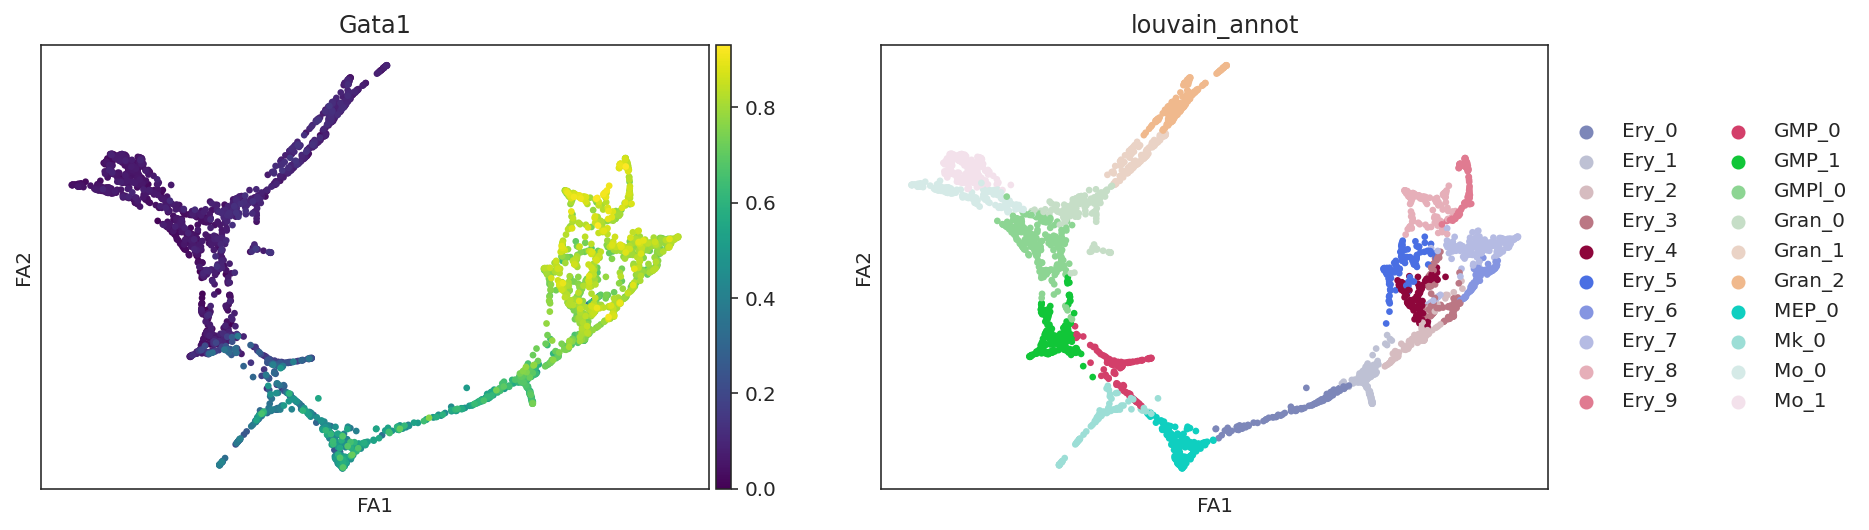

In [10]:
# Check gene expression 
goi = "Gata1"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

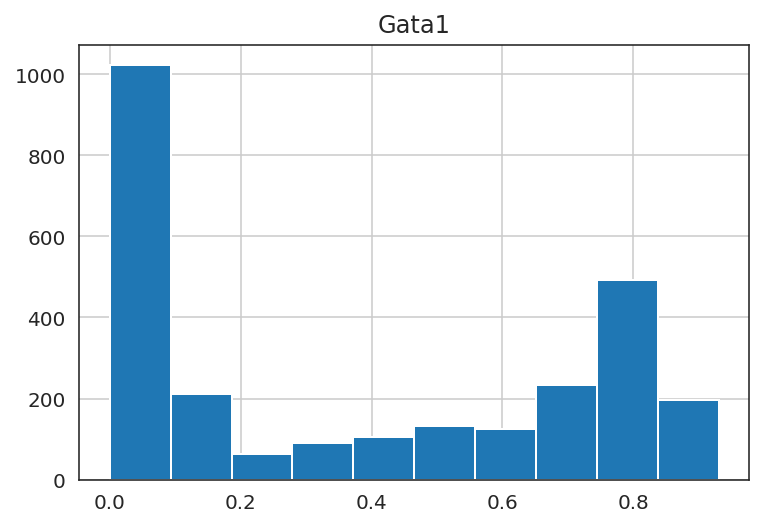

In [11]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

## 3.2. calculate future gene expression after perturbation.

Although you can use any gene expression value for the input of in silico perturbation, we recommend avoiding extreme values which are far from natural gene expression ranges. If you set Gata1 gene expression to 100, for example, it may lead to biologically infeasible results.

Here we simulate Gata1 KO; we predict what happens to the cells if Gata1 gene expression changed into 0.

In [14]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

## 3.3. calculate transition probability between cells

In the step above, we simulated simulated future gene expression values after perturbation. This prediction is based on itelative calculations of signal propagations within the GRN.

Next step, we will calculate the probabilityof a cell state transition based on the simulated data. Using the transition probability between cells, we can predict how a cell changes after perturbation.

This transition probability will be used in two ways.

(1) Visualization of directed trjectory graph.

(2) Markof simulation.

In Step 4.2 and 4.3, we usefunctions imported from the velocytoloom class in velocyto.py. Please see the documentation of VelocytoLoom for more information. http://velocyto.org/velocyto.py/fullapi/api_analysis.html

In [15]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr = 0.05)

# 3.4 Extract transition probability data 

You can get transition probability data as follows.

In [16]:
def extract_transition_probability(oracle_object):
    # Cell name
    cell_name = oracle.adata.obs.index
    
    # Get probability as numpy matrix
    transition_prob = oracle.transition_prob
    
    # Convert probability into data frame.
    df_transition_prob = pd.DataFrame(transition_prob, index=cell_name, columns=cell_name)
    df_transition_prob = df_transition_prob.rename_axis(index="From", columns="To")
    
    return df_transition_prob

In [17]:
df_transition_prob = extract_transition_probability(oracle)

### You will get data frame, the shape is (n_cell, n_cell).
The index name and column name shows cell name in your scRNA-seq data.

You can access transition probability of "CELL_NAME_X"
as follows.

`df_transition_prob.loc["CELL_NAME_X", :]`



In [20]:
df_transition_prob

To,0,1,2,3,4,5,6,7,8,9,...,2720,2721,2722,2723,2724,2725,2726,2727,2728,2729
From,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001295,0.000000,0.0
1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.000000,0.0,0.000000,0.000000,0.000509,0.0,0.0,0.0,0.0,0.002575,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.004239,0.0
4,0.000000,0.0,0.005941,0.000000,0.000000,0.0,0.0,0.0,0.0,0.003459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2726,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2727,0.000721,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [30]:
# Let's pick up one cell to visuazlize transition probability. 
cell_name = np.random.choice(oracle.adata.obs.index, 1)[0]

print("Selected cell_name is ", cell_name)

Selected cell_name is  1026


In [31]:
# Pickup transition probabilities of the cell of interest
tp = df_transition_prob.loc[cell_name, :]

### Let's Visualize transition probability of selected cell.

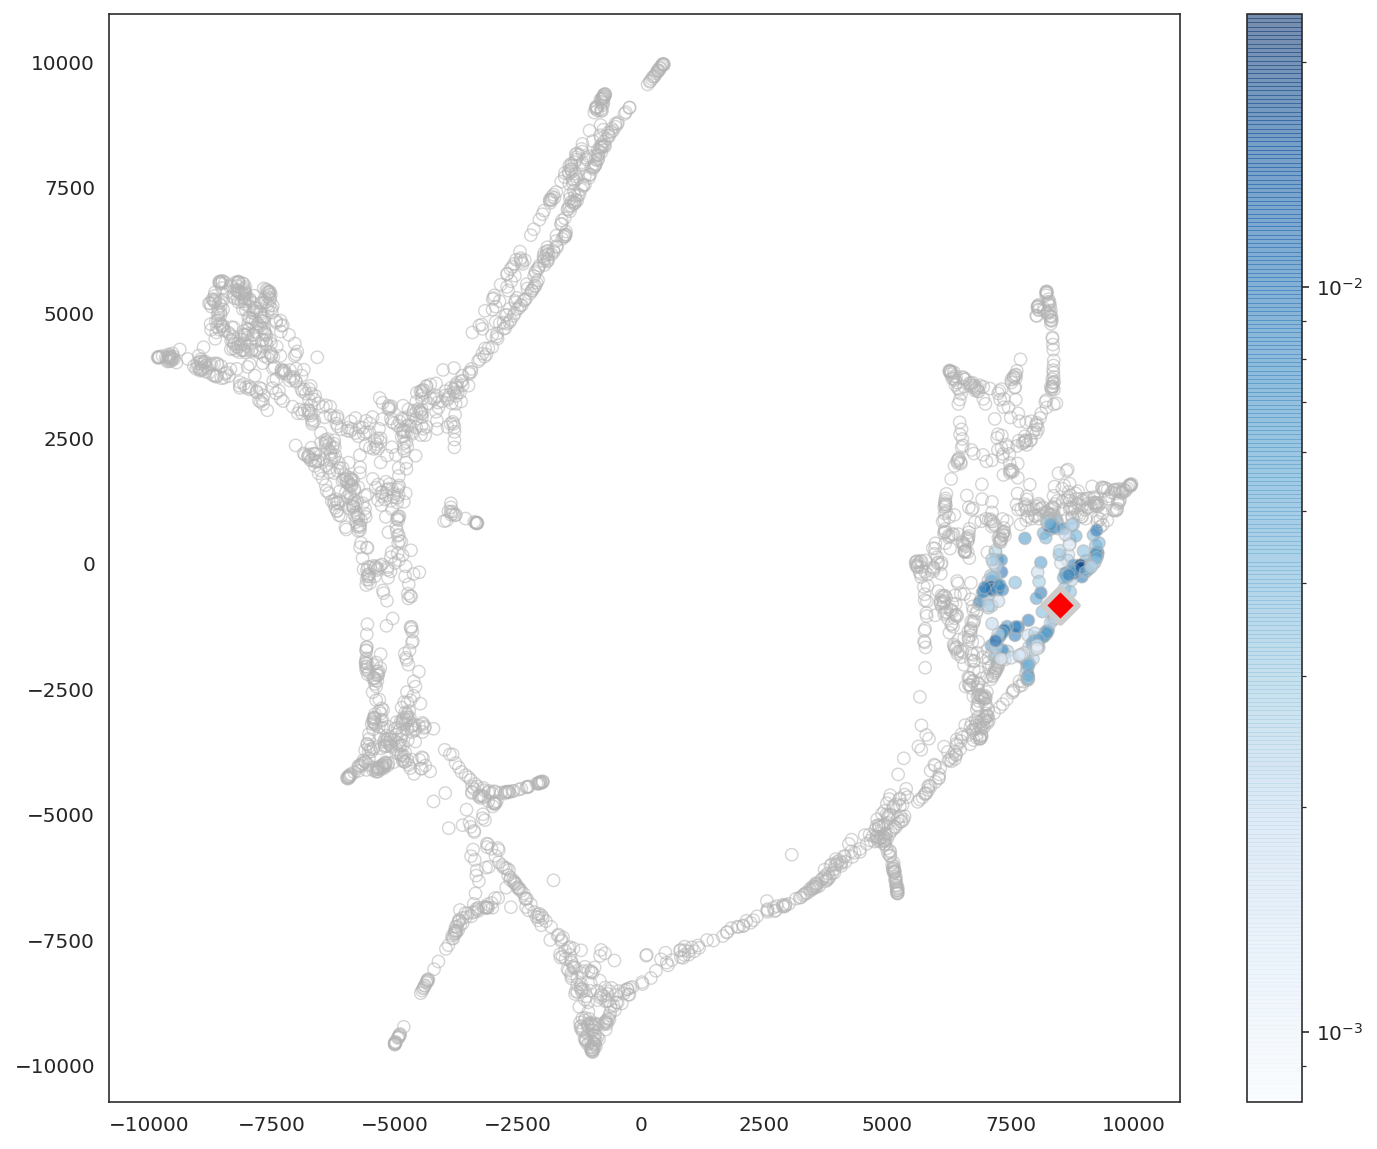

In [32]:
import matplotlib.colors as colors

fig = plt.figure(figsize=[12, 10])


# Show transition probability
ax = plt.scatter(oracle.embedding[:, 0], # x
                 oracle.embedding[:, 1], # y
                 c=tp, # Show transition probability as color
                 norm=colors.LogNorm(),
                 cmap="Blues", lw=0.7, s=38, alpha=0.55,  
                 edgecolor="0.7", rasterized=True)


# Show the cell we picked up.
ix = np.where(oracle.adata.obs.index == cell_name)[0][0]
plt.scatter(oracle.embedding[ix, 0], oracle.embedding[ix, 1],
            c="r", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")

# Show colorbar
plt.colorbar(ax)
plt.show()

### Let's do the same analysis 5 times.
### Randomly pick up cells and show transition probability.


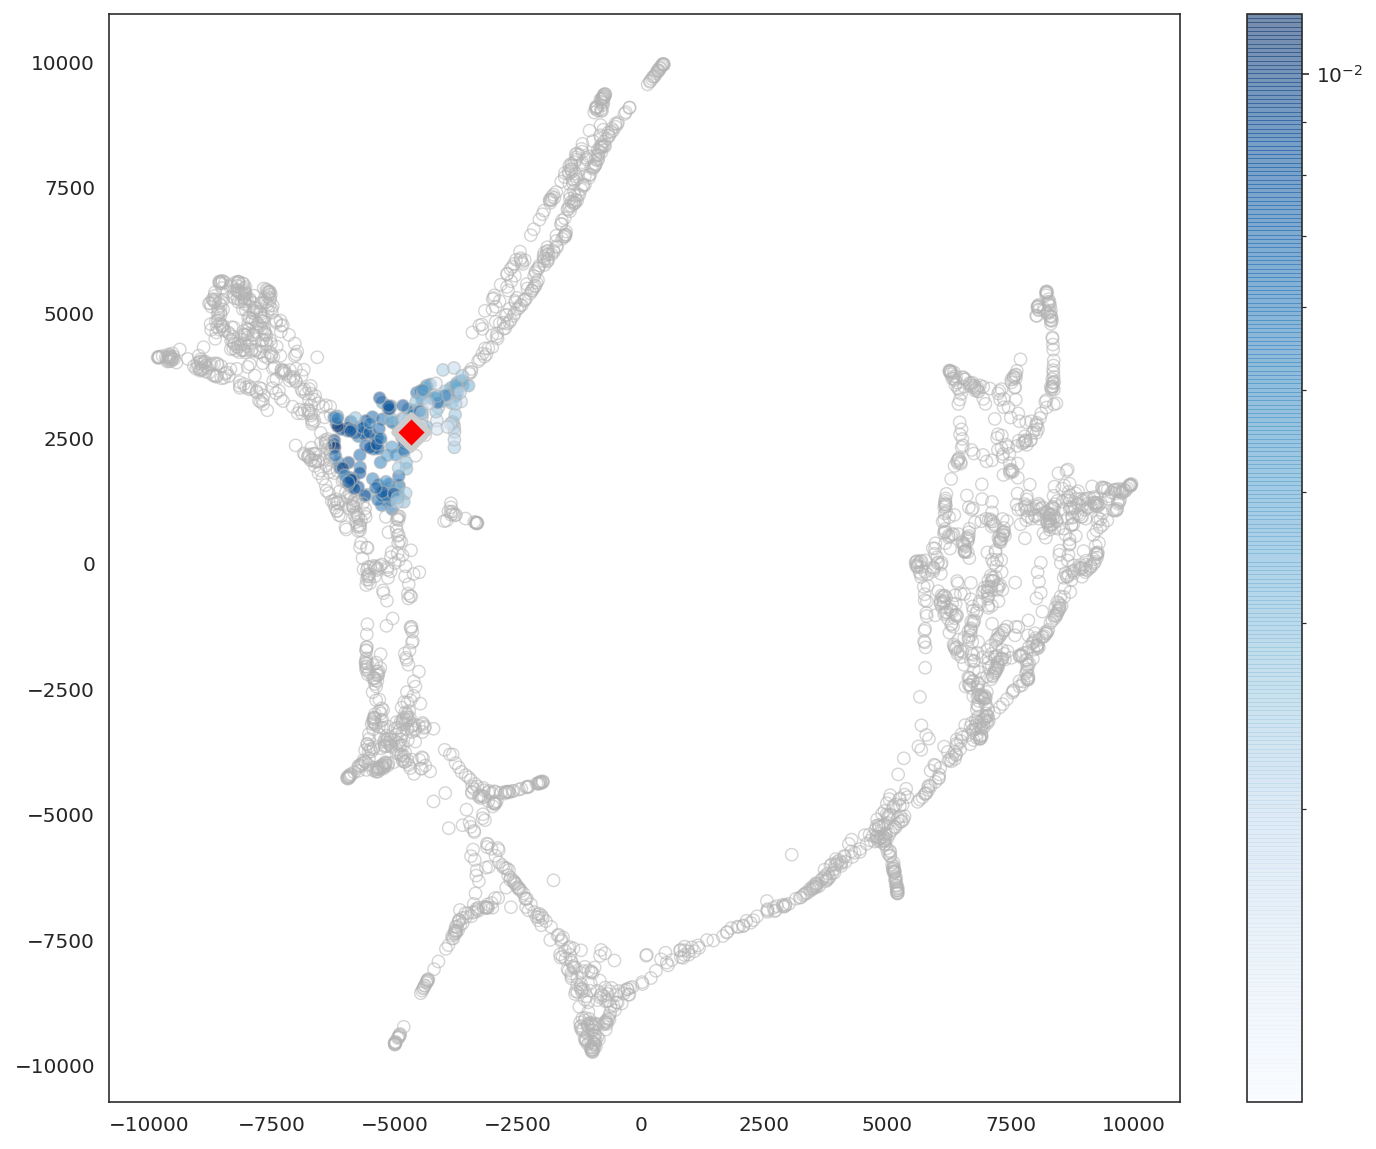

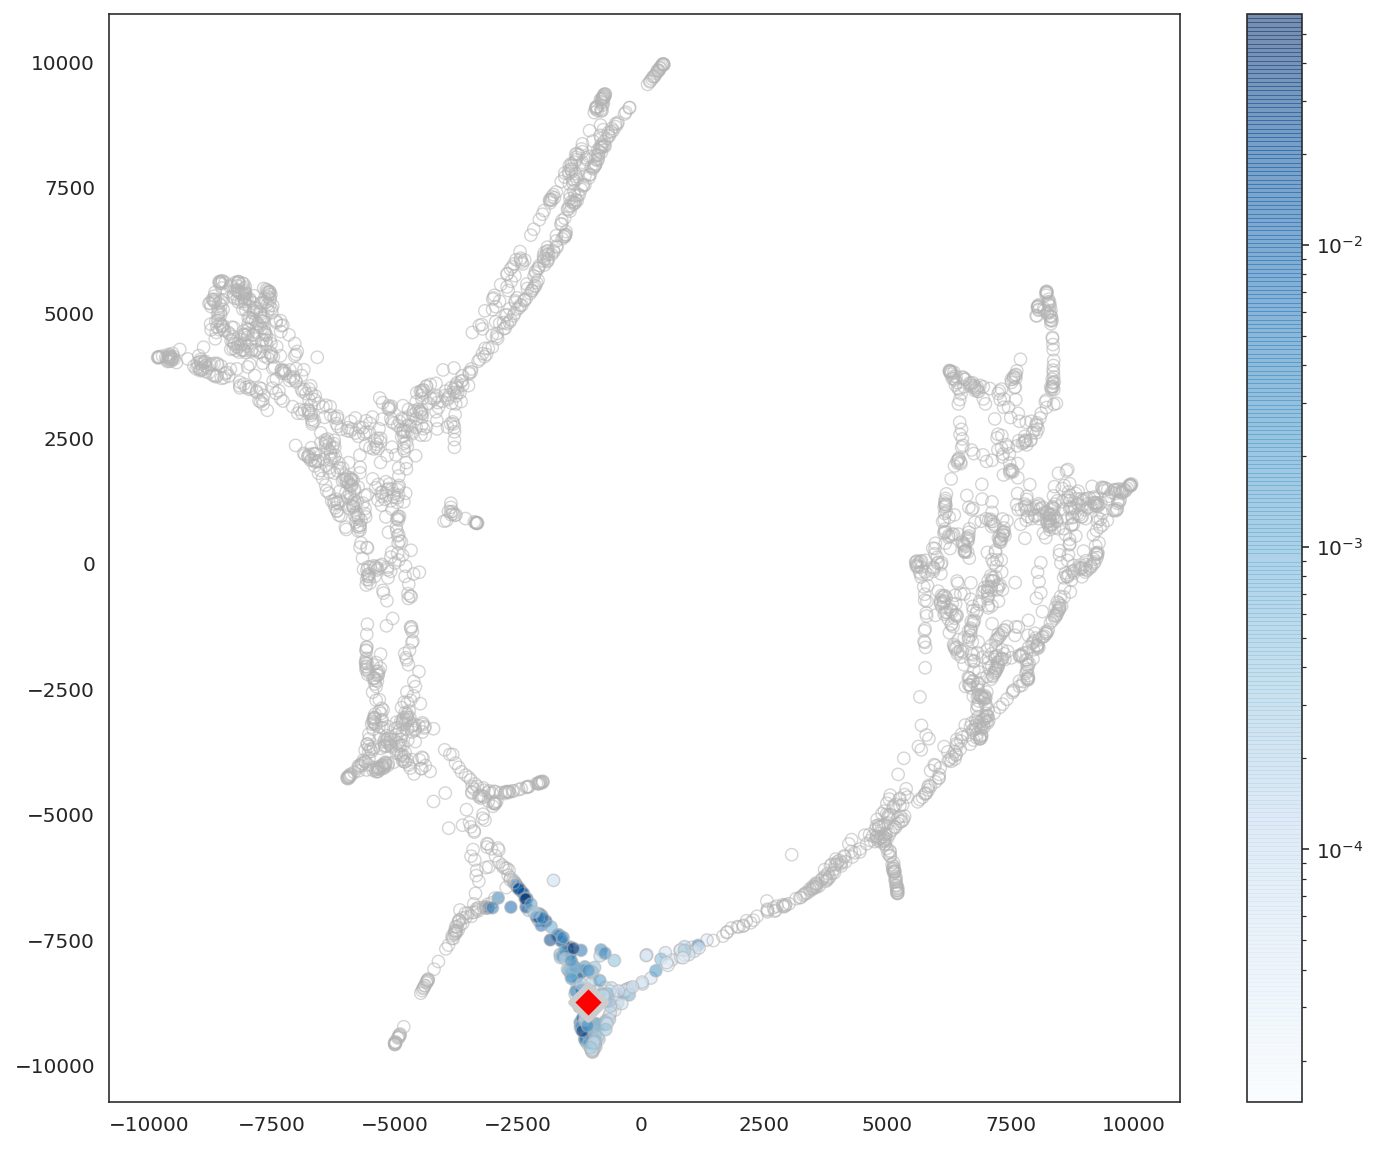

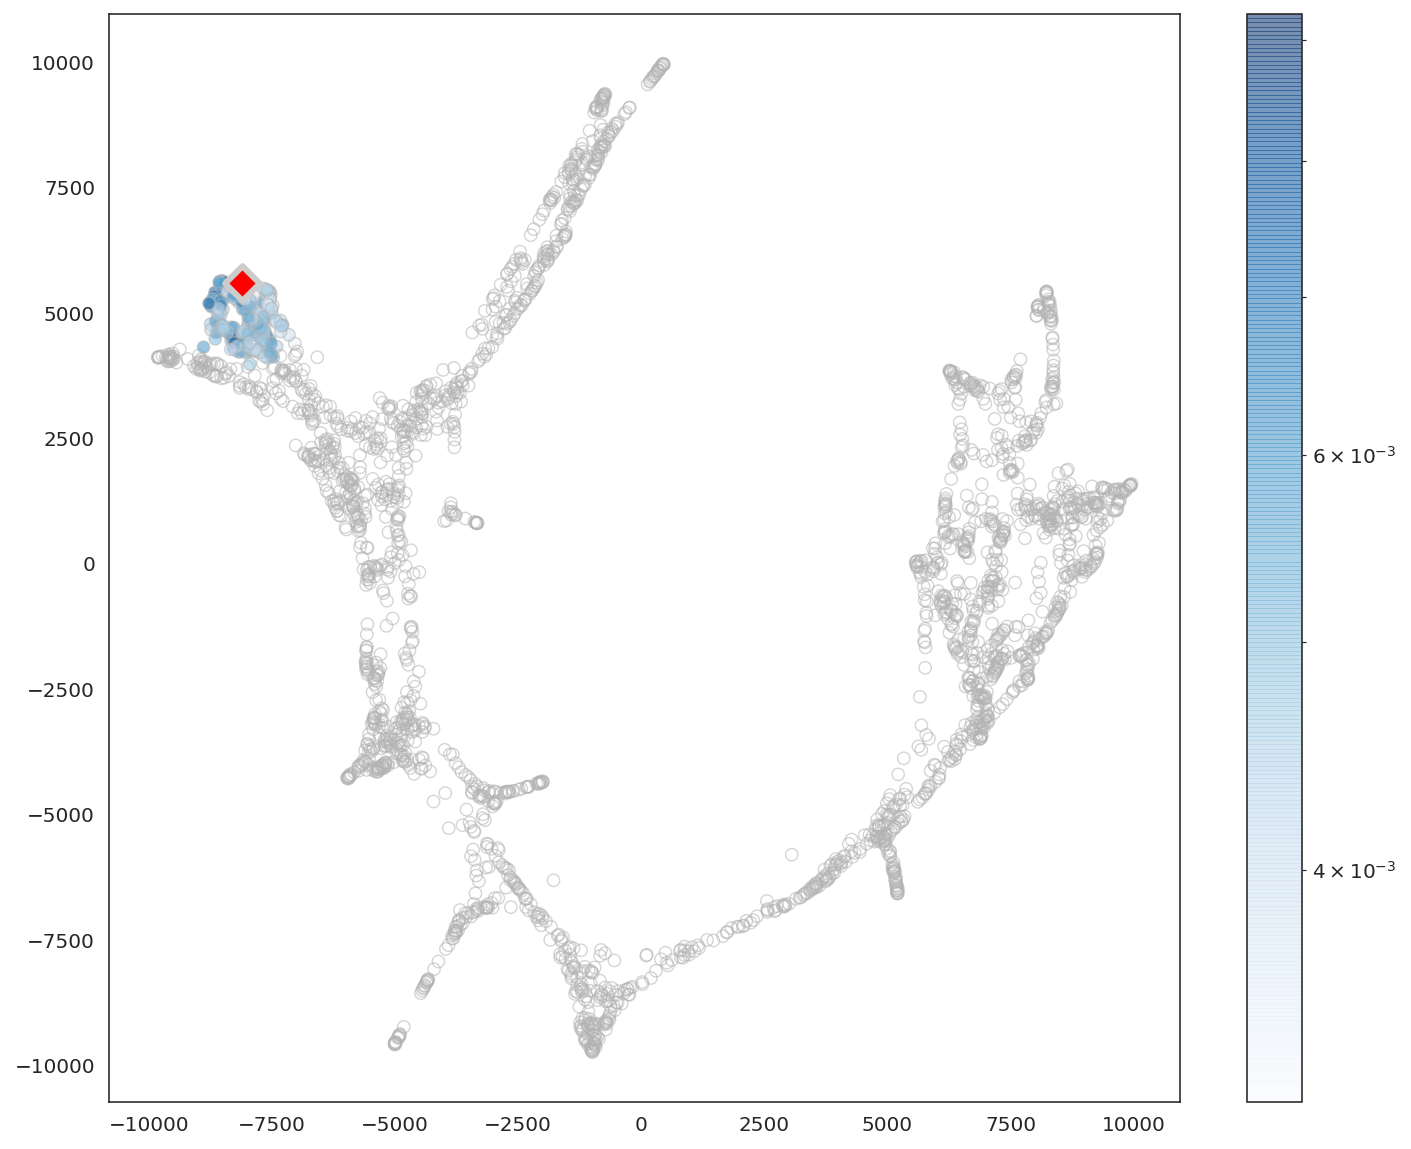

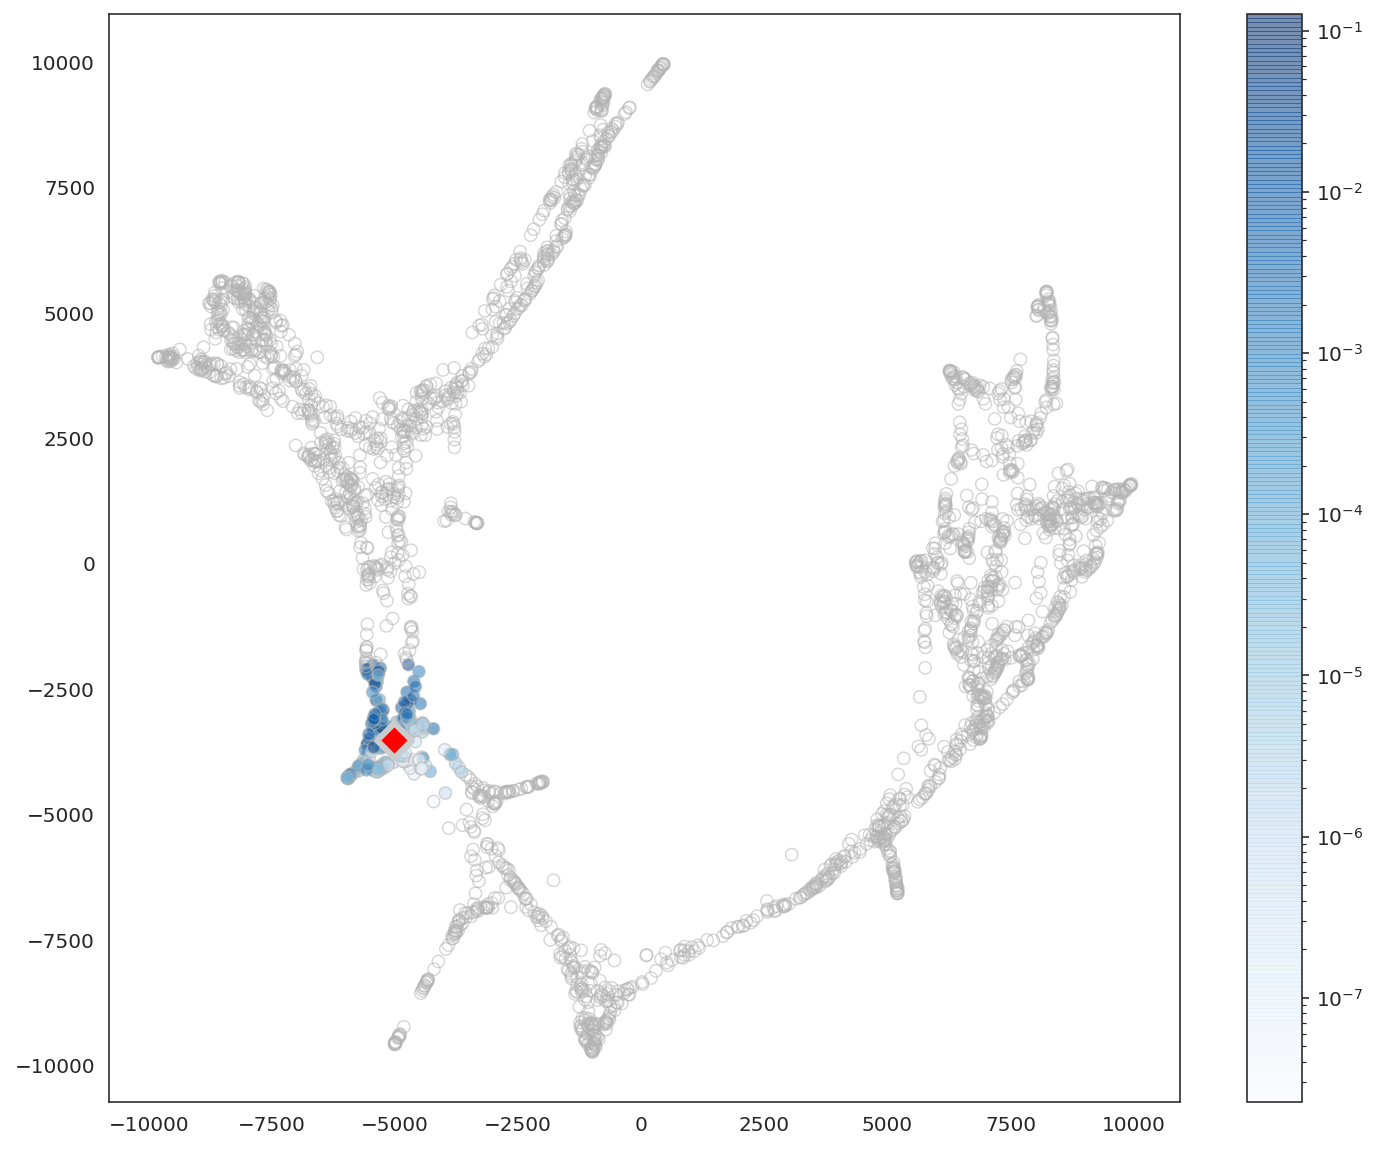

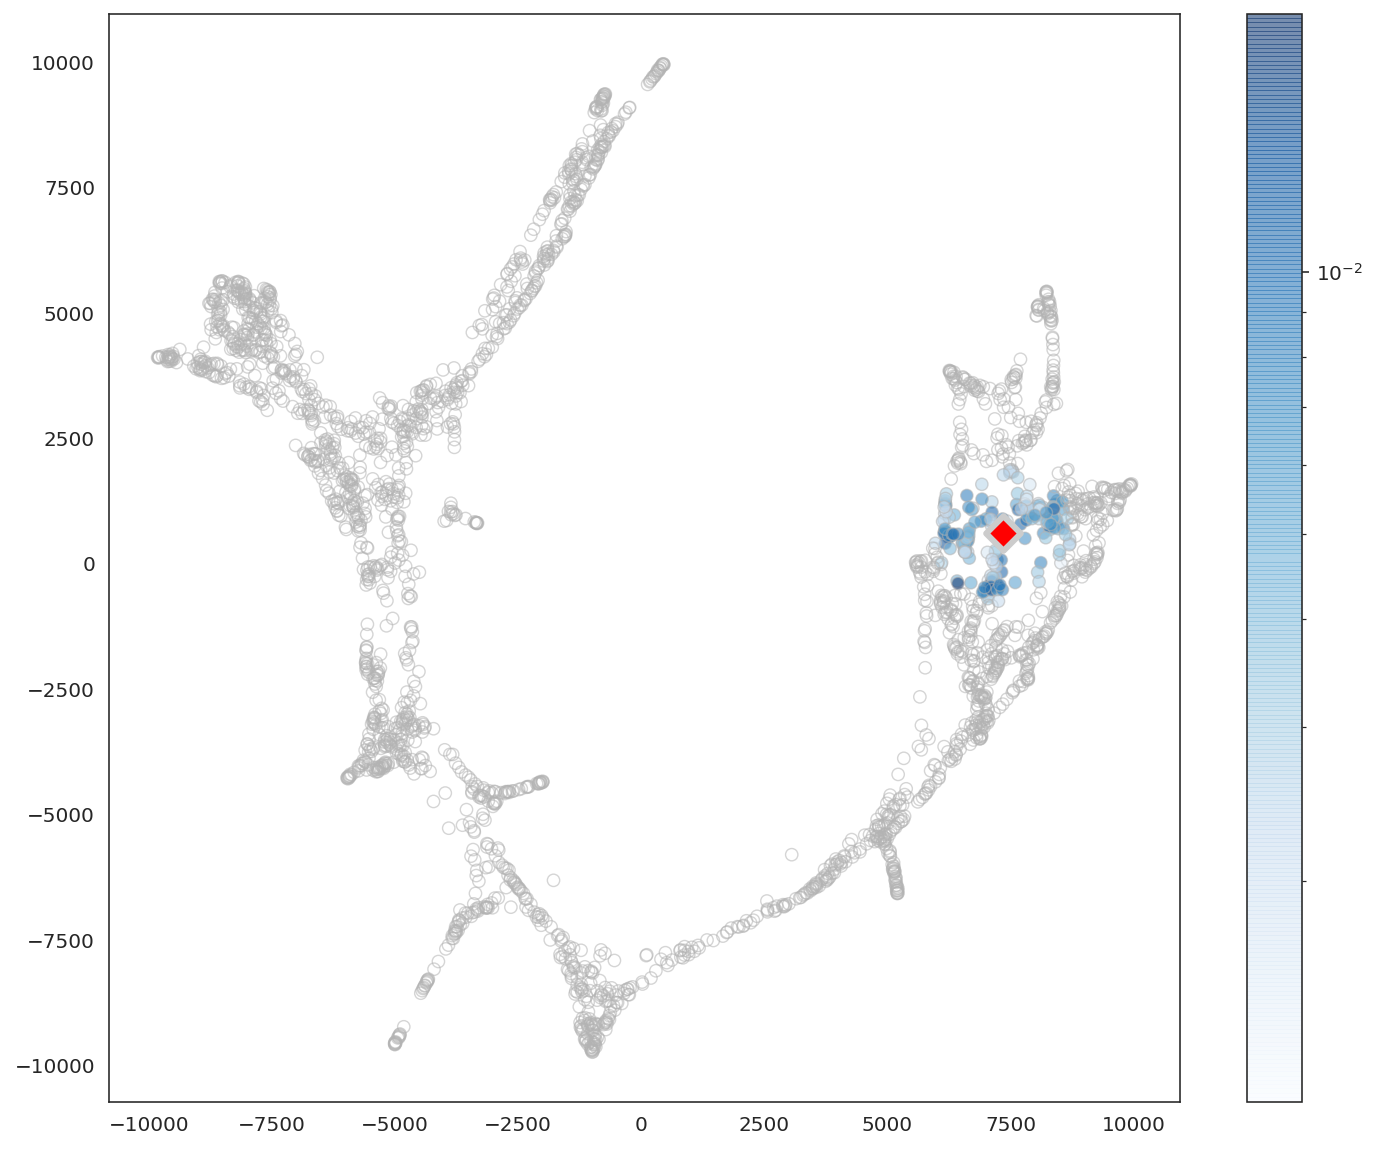

In [42]:
# Let's randomly pick up cells and show transition probability.

np.random.seed(123)
for i in range(5):
    
    # Let's pick up one cell to visuazlize transition probability. 
    cell_name = np.random.choice(oracle.adata.obs.index, 1)[0]

    print("Selected cell_name is ", cell_name)
    
    # Pickup transition probabilities of the cell of interest
    tp = df_transition_prob.loc[cell_name, :]
    
    
    import matplotlib.colors as colors


    fig = plt.figure(figsize=[12, 10])
    # Show transition probability
    ax = plt.scatter(oracle.embedding[:, 0], # x
                     oracle.embedding[:, 1], # y
                     c=tp, # Show transition probability as color
                     norm=colors.LogNorm(),
                     cmap="Blues", lw=0.7, s=38, alpha=0.55,  
                     edgecolor="0.7", rasterized=True)


    # Show the cell we picked up.
    ix = np.where(oracle.adata.obs.index == cell_name)[0][0]
    plt.scatter(oracle.embedding[ix, 0], oracle.embedding[ix, 1],
                c="r", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")

    # Show colorbar
    plt.colorbar(ax)
    plt.show()

This is Gata1 KO. Gata1 is knownt to promote cell differentiation toward MEP lineage.
As expected celloracle simulated that cells transitin probabilities are high at GMP side and the transition probabilities are low at the MEP side. 

# NOTE

1. CellOracle calculate transition probability between neighbors. 
 The number of neighbors can be adjusted by the parameter, `n_neighbors`.

 If you want to adjust the number of neighbors, please change `n_neibors` when you calculate transition probability.

 `oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1)`


2. Also, there is one more important parameter, `sampled_fraction`.
 If you set `sampled_fraction=0.8` for example, it means you will calculate transition probabilities for only 80% of neighbors. You can reduce calculation time and memory usage by setting lower sampled_fraction. It is particulary effective when you have large number of cells in your scRNA-seq data. But if you want to analyze the transition probability in detail, please set `sampled_fraction=1` so that you can use all neighbors for the calculation of transition probabilities.

### An example; n_neighbors=200, sampled_fraction=1



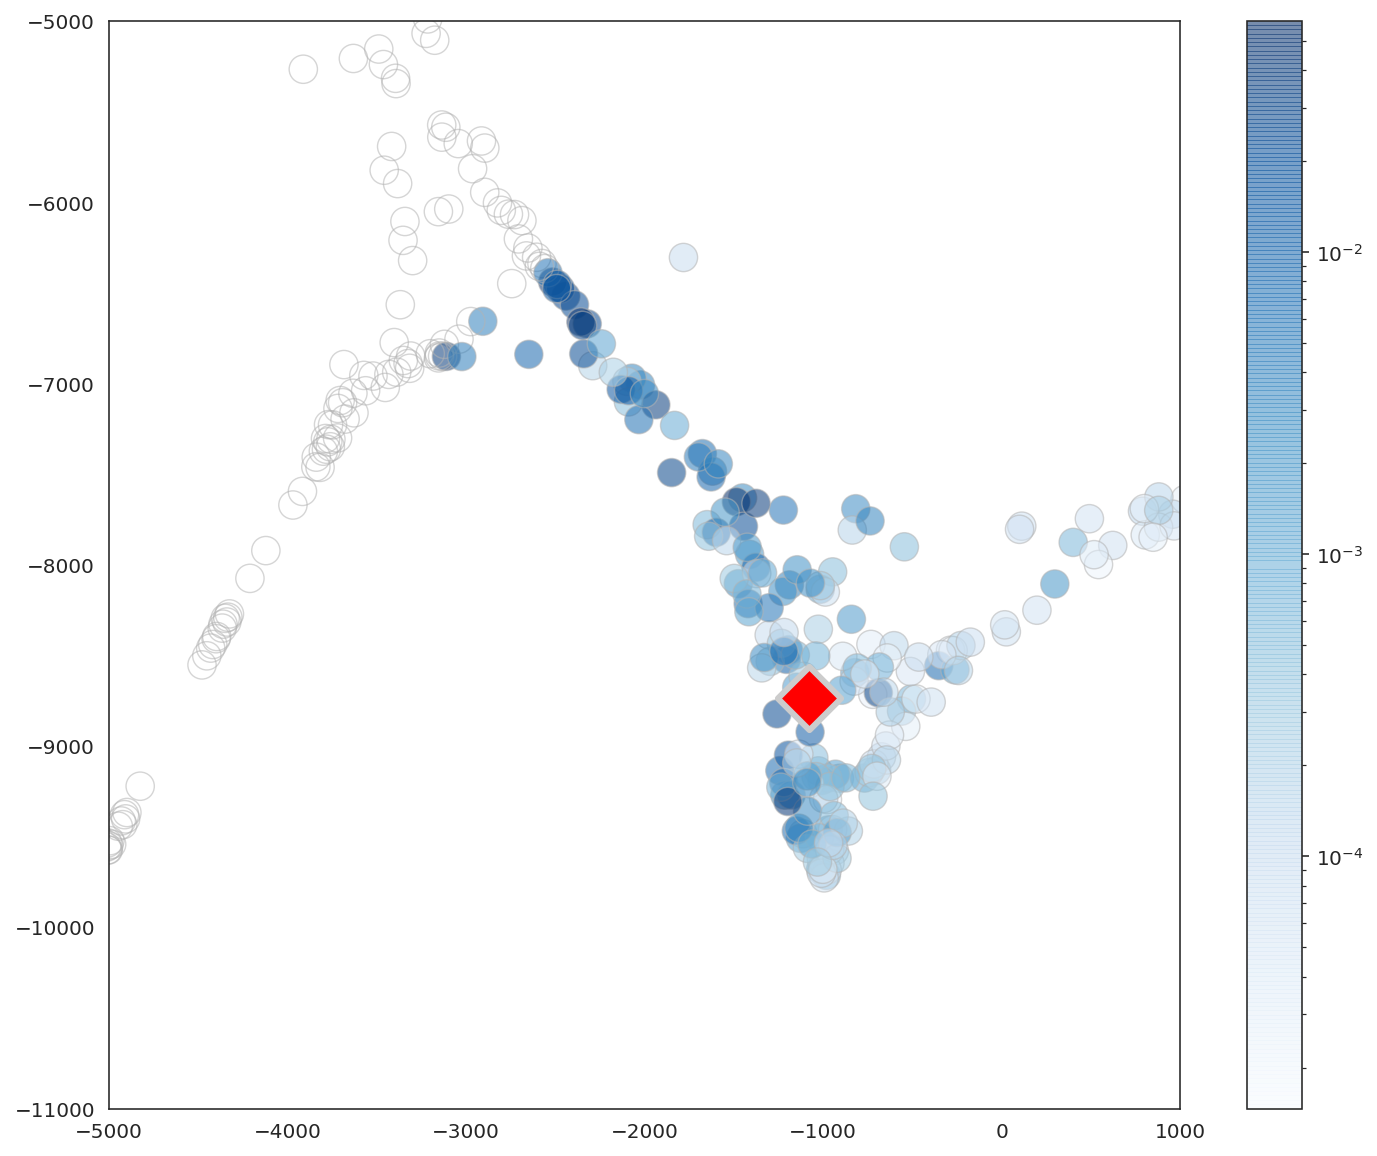

In [54]:
%%time
# Example; n_neighbors=200, sampled_fraction=1

# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr = 0.05)


# Pickup transition probabilities of the cell of interest
cell_name = "1150"

df_transition_prob = extract_transition_probability(oracle)
tp = df_transition_prob.loc[cell_name, :]


fig = plt.figure(figsize=[12, 10])
# Show transition probability
ax = plt.scatter(oracle.embedding[:, 0], # x
                 oracle.embedding[:, 1], # y
                 c=tp, # Show transition probability as color
                 norm=colors.LogNorm(),
                 cmap="Blues", lw=0.7, s=200, alpha=0.55,  
                 edgecolor="0.7", rasterized=True)


# Show the cell we picked up.
ix = np.where(oracle.adata.obs.index == cell_name)[0][0]
plt.scatter(oracle.embedding[ix, 0], oracle.embedding[ix, 1],
            c="r", alpha=1, s=500, lw=3, edgecolor="0.8", marker="D")


plt.xlim([-5000, 1000])
plt.ylim([-11000, -5000])
# Show colorbar
plt.colorbar(ax)
plt.show()

### An example; n_neighbors=200, sampled_fraction=0.3



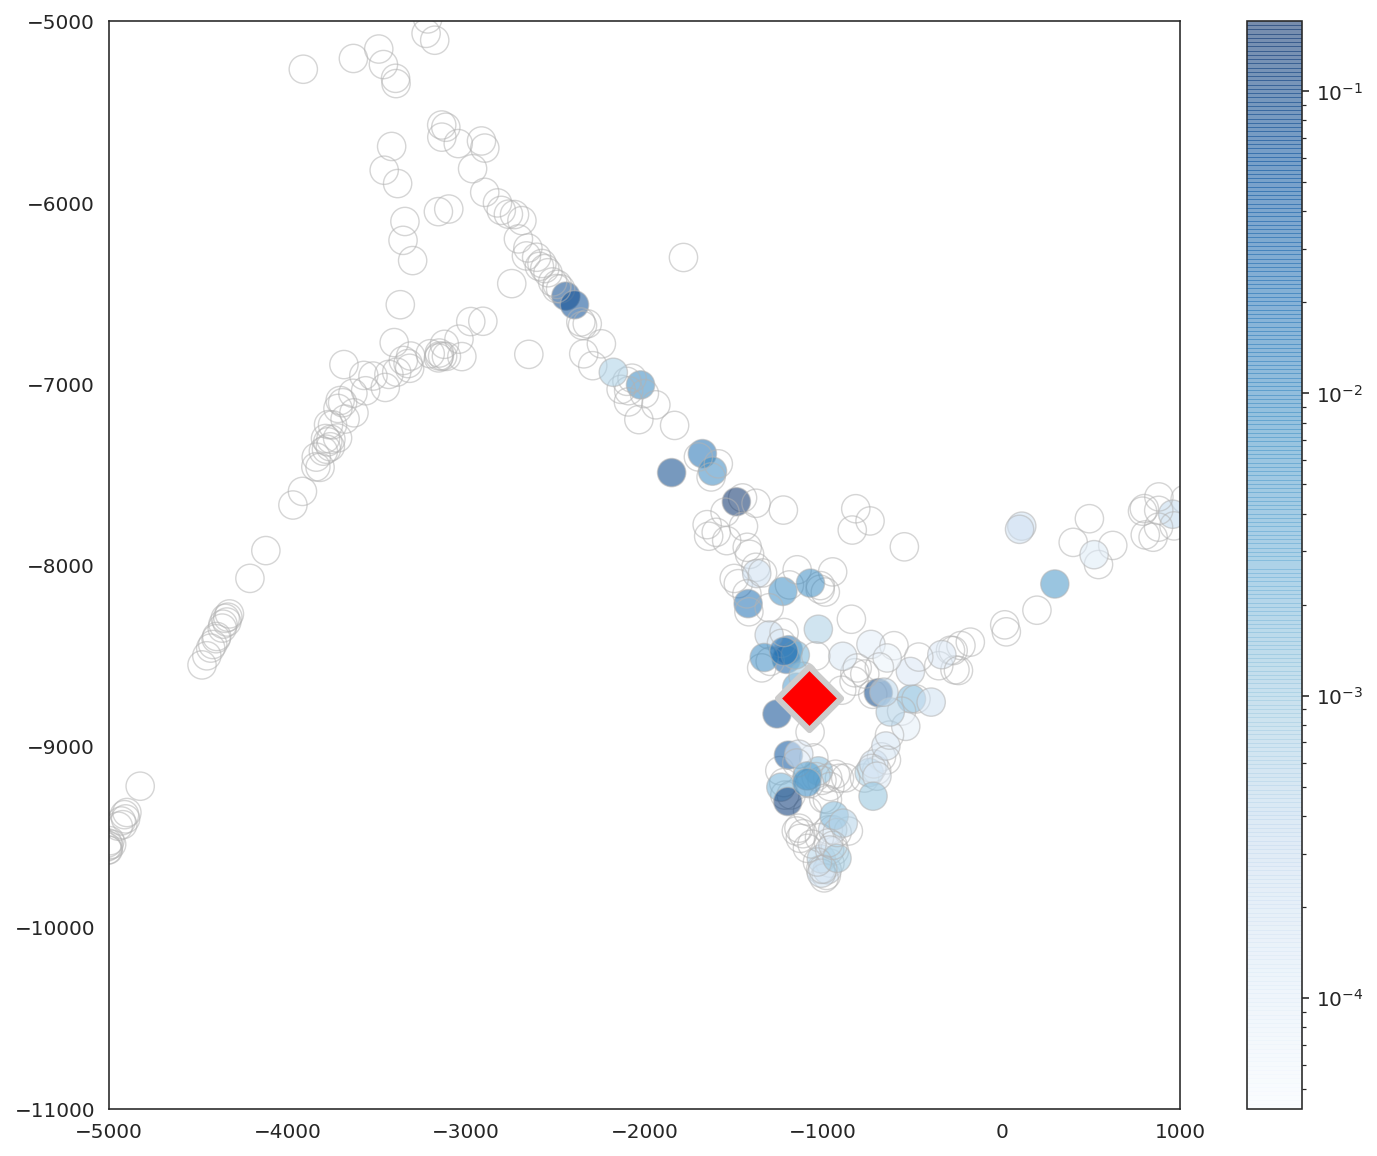

In [55]:
%%time
# Example; n_neighbors=200, sampled_fraction=1

# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=0.3)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr = 0.05)


# Pickup transition probabilities of the cell of interest
cell_name = "1150"

df_transition_prob = extract_transition_probability(oracle)
tp = df_transition_prob.loc[cell_name, :]


fig = plt.figure(figsize=[12, 10])
# Show transition probability
ax = plt.scatter(oracle.embedding[:, 0], # x
                 oracle.embedding[:, 1], # y
                 c=tp, # Show transition probability as color
                 norm=colors.LogNorm(),
                 cmap="Blues", lw=0.7, s=200, alpha=0.55,  
                 edgecolor="0.7", rasterized=True)


# Show the cell we picked up.
ix = np.where(oracle.adata.obs.index == cell_name)[0][0]
plt.scatter(oracle.embedding[ix, 0], oracle.embedding[ix, 1],
            c="r", alpha=1, s=500, lw=3, edgecolor="0.8", marker="D")


plt.xlim([-5000, 1000])
plt.ylim([-11000, -5000])
# Show colorbar
plt.colorbar(ax)
plt.show()